# Comparison of Edges-Analysis Beam Factor to Alan's

In this notebook, we calculate the beam factor using `edges-analysis`, and compare it to Alan's compute beam factor from the Nature Paper for day 260. In order to provide insight into potential differences, we have a few preliminary sections dealing with components of the beam factor, like the computation of coordinates, the beam itself, and the sky map, before moving to the beam factor proper.

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy import coordinates as apc
from astropy.time import Time, TimeDelta
from edges_cal import modelling as mdl
from matplotlib.colors import LogNorm

from edges_analysis import beams, sky_models

%load_ext autoreload
%autoreload

from read_acq import _coordinates as crda

from edges_analysis import const

In [2]:
plt.style.use("dark_background")

In [3]:
alans_beam = beams.Beam.from_file(
    band="low",
    beam_file="/data4/nmahesh/edges/code_from_alan_org/newniv.txt",
    rotation_from_north=-6,
)
alan_beam_factor = np.genfromtxt(
    "/data4/nmahesh/edges/alans-pipeline/scripts/H2Case/beamcorr_626.txt"
)

In [4]:
sky_model = sky_models.Haslam408AllNoh()

## Coordinates

To obtain the beam factor, we must rotate the coordinates of the sky model into the antenna-centric frame, i.e. convert the galactic coordinates to Azimuth and Elevation. In `edges-analysis`, we by default use `astropy` to do these coordinate calculations, based on an input LST. Alan uses his own C-functions to do the rotation, based on an initial time (in the format of seconds since New Year 1970). 

To obtain closest comparison to Alan, we added a module, `_coordinates_alan` to `edges-analysis` that transcribes Alan's specific coordinate calculations into Python to be used pretty much just for this comparison.

First, let's read in the output of Alan's code (to obtain this data, we copied out just the coordinate calculation functions from Alan's C code into a new C-file, and ran them for time=1474043217.333, which is the same time as the _first_ LST bin in day 260, according to Alan's code):

In [5]:
aglat, aglon, araa, adec, aazz, ael = np.genfromtxt(
    "/home/smurray/data4/Projects/radio/EOR/Edges/alans-pipeline/coords.txt"
).T
seconds_since_ny1970 = 1474043217.33333333
loc = const.KNOWN_LOCATIONS["alan-edges"]

### Compare To Astropy's Calculation

First, let's compare Alan's output az/el to those that come from astropy. To use astropy, we need to set up a time to which to rotate the coordinates. To allow for the best possible match to Alan, it's a little tricky to know which time to use. Alan uses an input time in "seconds since New Year 1970", which is something we could also do. However, the other option is to use a time close to his starting time that most closely matches the *LST* that he obtains at that time. 

We first use the following time, which matches (to second precision) the time listed by the output of Alan's code:

In [6]:
t = Time("2016-09-16T16:26:57", format="isot", scale="utc")

Interestingly, adding the correct number of seconds since 1970 directly in astropy gives a very slightly different time:

In [7]:
_t_from_astropy = Time("1970-01-01T00:00:00", format="isot", scale="utc") + TimeDelta(
    seconds_since_ny1970, format="sec", scale="ut1"
)

In [8]:
print(
    "Difference between Alan's initial time output compared to astropy's calc: ",
    (_t_from_astropy - t).sec,
    "seconds",
)

Difference between Alan's initial time output compared to astropy's calc:  1.4016834921005028 seconds


It's quite possible that I'm using the wrong scale for doing the astropy calculation above, so we're just going to use Alan's output for now.

We check the derived LST from this time:

In [9]:
t.sidereal_time("apparent", longitude=loc.lon).hour

23.95228416151602

This is close to, but not exactly equivalent to 23.952541, which is the number that Alan's code prints out. We'll use that number directly in the next subsection.

In [10]:
# get the galactic coordinates from the sky model
c = sky_model.coords.reshape((512, 1024))

Note here we use the "alan-edges" location for low-2, which is very slightly different from the default edges location used in edges-analysis.

In [11]:
antenna_frame = apc.AltAz(location=loc, obstime=t)

In [12]:
altaz = c.transform_to(antenna_frame)

In [13]:
alan_altaz = apc.SkyCoord(az=aazz * u.rad, alt=ael * u.rad, frame=antenna_frame)

In [14]:
diff = altaz.separation(alan_altaz.reshape(altaz.shape))

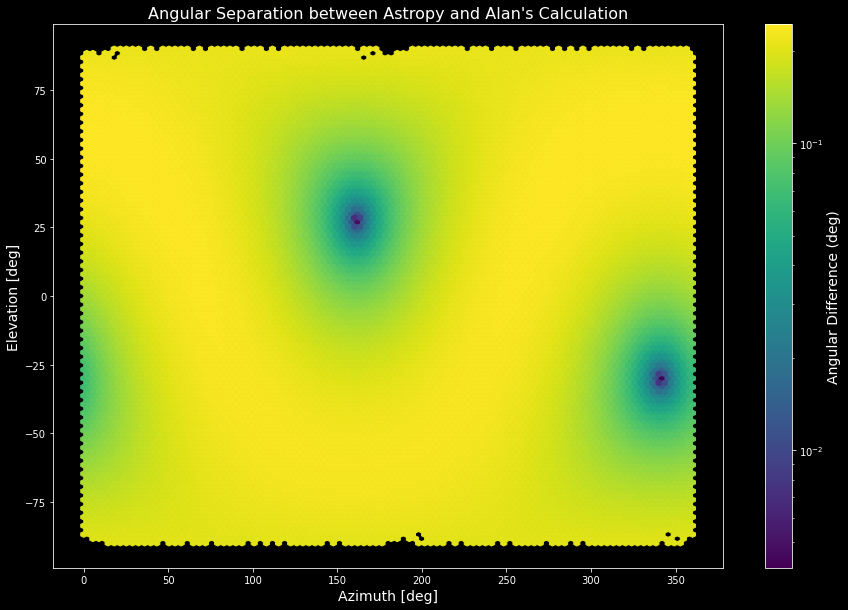

In [15]:
plt.figure(figsize=(15, 10))
plt.hexbin(
    aazz * 180 / np.pi, ael * 180 / np.pi, np.abs(diff).flatten().deg, norm=LogNorm()
)
plt.xlabel("Azimuth [deg]", fontsize=14)
plt.ylabel("Elevation [deg]", fontsize=14)
cbar = plt.colorbar()
plt.title("Angular Separation between Astropy and Alan's Calculation", fontsize=16)
cbar.set_label("Angular Difference (deg)", fontsize=14)

Let's try again, but this time let's try matching up the LST exactly between the codes:

In [16]:
req_lst = 23.952541

In [17]:
newt = t.copy()

In [18]:
diff_sec = 1000
while diff_sec > 0.0036:
    diff_sec = (req_lst - newt.sidereal_time("apparent", longitude=loc.lon).hour) * 3600
    print(diff_sec)
    newt = newt + TimeDelta(diff_sec, format="sec")

0.9246185423322117
-0.0025314125451814107


In [19]:
antenna_frame = apc.AltAz(location=loc, obstime=newt)

In [20]:
altaz = c.transform_to(antenna_frame)
alan_altaz = apc.SkyCoord(az=aazz * u.rad, alt=ael * u.rad, frame=antenna_frame)
diff = altaz.separation(alan_altaz.reshape(altaz.shape))

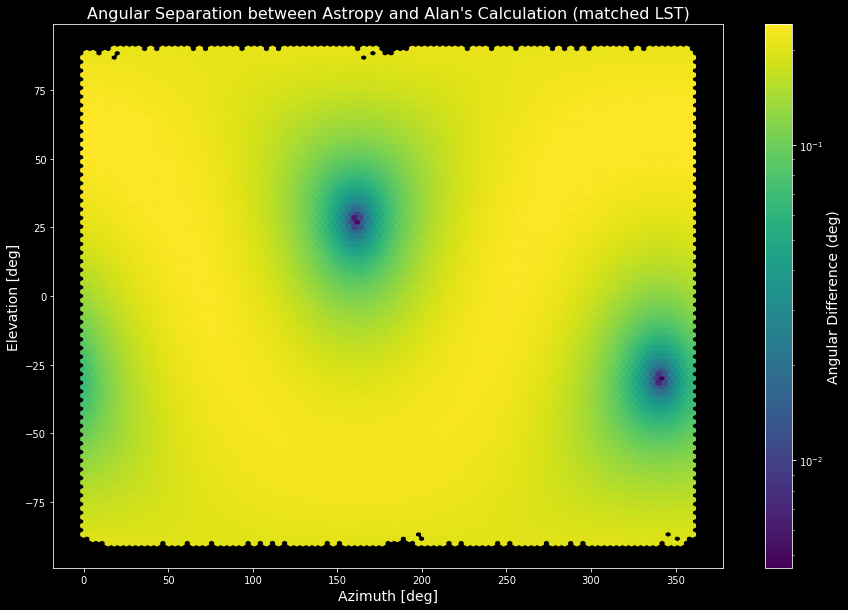

In [21]:
plt.figure(figsize=(15, 10))
plt.hexbin(
    aazz * 180 / np.pi, ael * 180 / np.pi, np.abs(diff).flatten().deg, norm=LogNorm()
)
plt.xlabel("Azimuth [deg]", fontsize=14)
plt.ylabel("Elevation [deg]", fontsize=14)
cbar = plt.colorbar()
plt.title(
    "Angular Separation between Astropy and Alan's Calculation (matched LST)",
    fontsize=16,
)
cbar.set_label("Angular Difference (deg)", fontsize=14)

So, matching the LST didn't help us very much.

### Compare Alan's Coordinate Functions to Mine

Next, we make sure that the transcribed functions from Alan's code directly match Alan's output.

In [22]:
gstt = crda.gst(seconds_since_ny1970)
mya_raa, mya_dec = crda.galactic_to_radec(
    sky_model.coords.b.deg, sky_model.coords.l.deg
)
mya_azz, mya_el = crda.radec_azel(gstt - mya_raa + loc.lon.rad, mya_dec, loc.lat.rad)

First, we check whether the galactic-to-ra/dec conversion is accurate:

In [23]:
my_radec = apc.SkyCoord(ra=mya_raa * u.rad, dec=mya_dec * u.rad, frame="icrs")
alan_radec = apc.SkyCoord(ra=araa * u.rad, dec=adec * u.rad, frame="icrs")
diff = my_radec.separation(alan_radec.reshape(my_radec.shape))

In [24]:
print(f"Maximum angular difference in RA/DEC: {np.max(diff.deg):.2e} deg")

Maximum angular difference in RA/DEC: 3.74e-09 deg


It is very accurate!

Now, let's check the AZ/EL:

In [25]:
my_azel = apc.SkyCoord(alt=mya_el * u.rad, az=mya_azz * u.rad, frame=antenna_frame)
alan_azel = apc.SkyCoord(alt=ael * u.rad, az=aazz * u.rad, frame=antenna_frame)
diff = my_azel.separation(alan_azel.reshape(my_azel.shape))

In [26]:
print(f"Maximum angular difference in AZ/EL: {np.max(diff.deg):.2e} deg")

Maximum angular difference in AZ/EL: 3.58e-09 deg


We can confidently use the transcribed coordinate calculations in edges-analysis, to the precision of 1e-9 degrees. 

## Beam Map Interpolated To Sky

Now, we want to make sure we're doing the beam interpolation well. Alan uses "nearest neighbours" beam interpolation -- i.e. if a sky pixel appears in a certain grid cell of the beam, it gets the value at the center of that grid cell. This means that even small coordinate offsets, of 1e-9 deg say, can shift coordinates into different pixels, which can have reasonably large effects. 

In this section, we focus just on the beam at 40 MHz (the first channel in our beam data). We output the _interpolated_ beam (onto sky model coordinates) from Alan's code directly, along with other information.

In [27]:
alan_maps = np.genfromtxt(
    "/home/smurray/data4/Projects/radio/EOR/Edges/alans-pipeline/scripts/skymap0.txt",
    skip_header=1,
)
alan_mask = alan_maps[:, 1] > 0

az_alan, el_alan, alan_sky, alan_beam, alan_beamref, _, iaz, iel, alan_solid_angle = (
    alan_maps[alan_mask].T
)

iaz = iaz.astype(int)
iel = iel.astype(int)

Now, we get the beam interpolation function from our beam:

In [28]:
beam_interpolator = alans_beam.angular_interpolator(0, interp_kind="nearest")

There's two ways we might want to check this: using exactly Alan's Az/El coordinates, and then using ours (computed with the transcribed C-code, see above).

### Using Alan's Coordinates Exactly

In [29]:
my_bm = beam_interpolator(az_alan, el_alan)
my_bm *= sky_model.pixel_res[alan_mask]

In [30]:
def plot_mapdiff(alan, me, az, el, normalize_to_mean: bool = True, vmax=None):
    diff = alan.flatten() - me.flatten()
    if normalize_to_mean:
        diff /= np.mean(alan)
    print(
        f"Worst offending pixel: {np.argmax(np.abs(diff))} with diff {diff[np.argmax(np.abs(diff))]}"
    )
    plt.figure(figsize=(15, 8))
    if vmax is None:
        vmin = -np.max(np.abs(diff))
        vmax = np.max(np.abs(diff))
    else:
        vmin = -vmax

    plt.hexbin(az, el, diff, cmap="bwr", vmin=vmin, vmax=vmax)
    plt.ylabel("Elevation [deg]", fontsize=14)
    plt.xlabel("Azimuth [deg]", fontsize=14)
    cbar = plt.colorbar()

    if normalize_to_mean:
        cbar.set_label("Difference as ratio to Mean", fontsize=14)

Worst offending pixel: 0 with diff -2.7440072453480168e-11


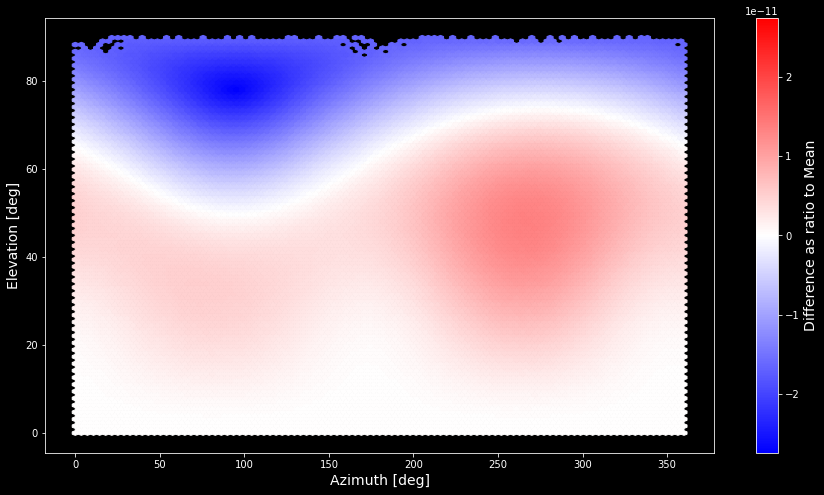

In [31]:
plot_mapdiff(alan_beam, my_bm, az_alan, el_alan)

These differences really are quite noise-like

### Using our computed coordinates

In [32]:
my_mask = mya_el > 0
my_bm = beam_interpolator(mya_azz[my_mask] * 180 / np.pi, mya_el[my_mask] * 180 / np.pi)
my_bm *= sky_model.pixel_res[my_mask]

Worst offending pixel: 0 with diff -2.7440072453480168e-11


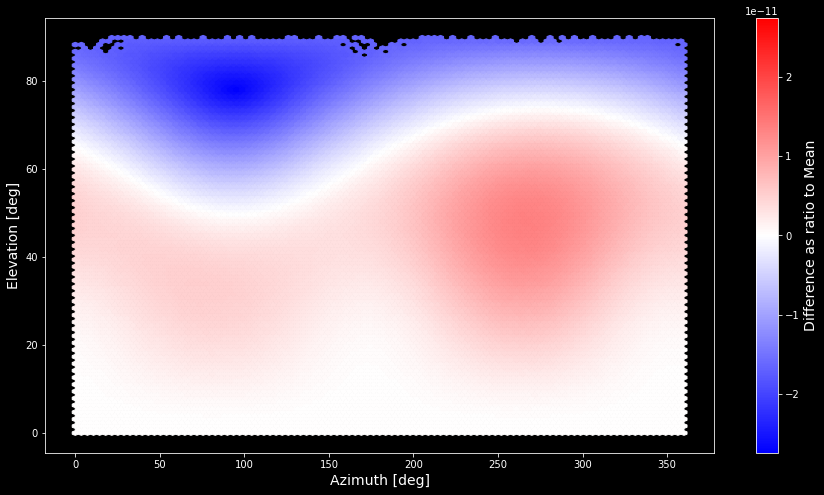

In [33]:
plot_mapdiff(alan_beam, my_bm, az_alan, el_alan)

This is also pretty much just noise like!

## Sky Map

Next we check that we're getting the right sky map (after applying spectral index):

In [34]:
thismap = sky_model.at_freq(40.0, index_model=sky_models.ConstantIndex())

In [35]:
diff = thismap[alan_mask] - alan_sky

In [36]:
np.max(np.abs(diff)), np.max(np.abs(diff)) / np.mean(alan_sky)

(4.656612873077393e-10, 4.639564129230288e-14)

I think this just numerical noise at this point.

## Beam Factor

Now we move on to the beam factor proper. We cheat a little bit by specifying the LST list directly based on Alan's output from his code. We probably have to get this to be automatically calculated in the future.

In [37]:
lst_list = np.arange(23.95244823089913, 35.7, 0.50441) % 24
assert len(lst_list) == 24

In [38]:
my_beamfac = beams.antenna_beam_factor(
    alans_beam,
    f_low=40 * u.MHz,
    f_high=100 * u.MHz,
    lsts=lst_list,
    sky_model=sky_models.Haslam408AllNoh(),
    index_model=sky_models.ConstantIndex(),
    normalize_beam=False,
    ground_loss_file=None,
    reference_frequency=75 * u.MHz,
    beam_smoothing=False,
    interp_kind="nearest",
    freq_progress=False,
    location=const.KNOWN_LOCATIONS["alan-edges"],
    sky_at_reference_frequency=False,
    use_astropy_azel=False,
)

24LST [00:49,  2.05s/LST]


In [39]:
fsum, fsum1, fsum2 = np.genfromtxt(
    "/home/smurray/data4/Projects/radio/EOR/Edges/alans-pipeline/scripts/beamfac0.txt",
    skip_header=1,
).T

In [42]:
fourier = mdl.Fourier(
    n_terms=31,
    transform=mdl.ShiftTransform(shift=75.0),
    period=1.2
    * my_beamfac.nfreq
    * (my_beamfac.frequencies[1] - my_beamfac.frequencies[0]),
)

In [44]:
integrated_beam_factor = my_beamfac.get_integrated_beam_factor(
    model=fourier, freqs=alan_beam_factor[:, 0]
)

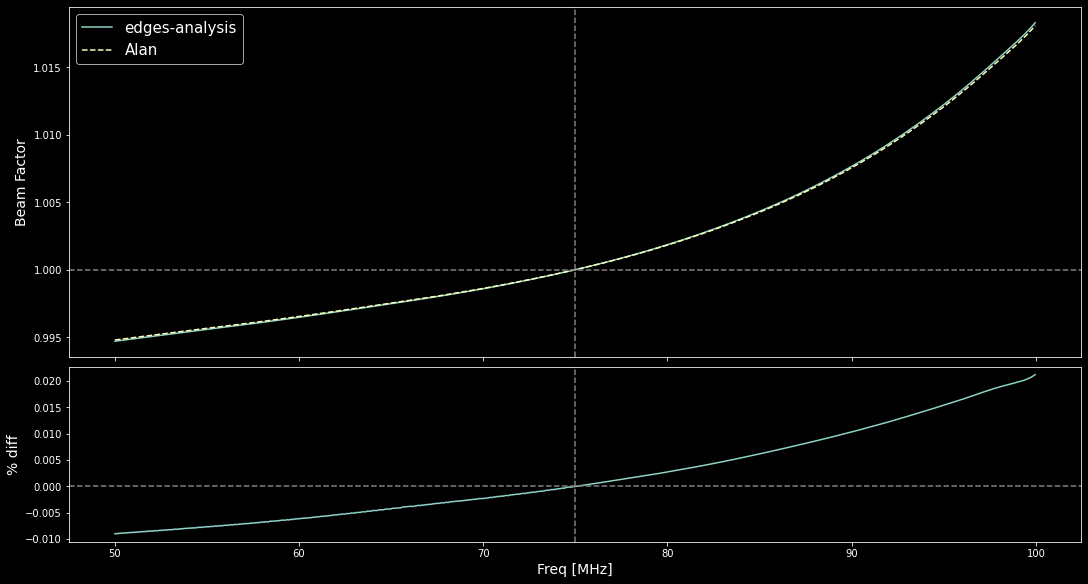

In [54]:
fig, ax = plt.subplots(
    2,
    1,
    sharex=True,
    constrained_layout=True,
    figsize=(15, 8),
    gridspec_kw={"height_ratios": (2, 1)},
)

ax[0].plot(
    alan_beam_factor[:, 0],
    integrated_beam_factor,
    label="edges-analysis",
)
ax[0].plot(alan_beam_factor[:, 0], 1 / alan_beam_factor[:, 3], label="Alan", ls="--")
ax[0].set_ylabel("Beam Factor", fontsize=14)
ax[0].legend(fontsize=15)

ax[1].plot(
    alan_beam_factor[:, 0], 100 * (integrated_beam_factor * alan_beam_factor[:, 3] - 1)
)
ax[1].set_ylabel("% diff", fontsize=14)
ax[1].set_xlabel("Freq [MHz]", fontsize=14)
ax[0].axvline(75.0, ls="--", color="gray")
ax[1].axvline(75.0, ls="--", color="gray")
ax[0].axhline(1.0, ls="--", color="gray")
ax[1].axhline(0.0, ls="--", color="gray");

Let's briefly test what the impact of this on the sky temperature is.

In [55]:
alan_sky_data = np.genfromtxt("bayesian-calibration-paper-code/alan-data/spe0.txt")

flg = alan_sky_data[:, 12] > 0
alan_sky_data = {
    "freq": alan_sky_data[:, 1][flg],
    "t_ant": alan_sky_data[:, 3][flg],
}

In [58]:
ibf = my_beamfac.get_integrated_beam_factor(model=fourier, freqs=alan_sky_data["freq"])

Need to get Alan's beam factor at the right frequencies.. just use a spline here, as it's just for illustration

In [59]:
from scipy.interpolate import interp1d

In [60]:
alan_bf = interp1d(alan_beam_factor[:, 0], alan_beam_factor[:, 3])(
    alan_sky_data["freq"]
)

Text(0.5, 0, 'Frequency [MHz]')

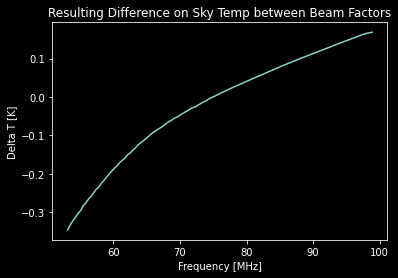

In [62]:
plt.plot(alan_sky_data["freq"], alan_sky_data["t_ant"] * (ibf * alan_bf - 1))
plt.title("Resulting Difference on Sky Temp between Beam Factors")
plt.ylabel("Delta T [K]")
plt.xlabel("Frequency [MHz]")